In [10]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import optuna

## Read in Data

### Transaction

In [11]:
# transaction = pd.read_csv("transaction.csv")
transaction = pd.read_csv("/Users/xinyinglu/Documents/OMSA 7406/ieee-fraud-detection/train_transaction.csv")
transaction_data = transaction.copy()


### Identity

In [12]:
identity = pd.read_csv("/Users/xinyinglu/Documents/OMSA 7406/ieee-fraud-detection/train_identity.csv")
identity_data = identity.copy()


### Transaction Model

In [13]:
y_t = transaction_data["isFraud"]
X_t = transaction_data.drop("isFraud", axis=1)


### Merged Model

In [14]:
merged_df = pd.merge(identity, transaction, on='TransactionID', how='inner')

y_m = merged_df["isFraud"]
X_m = merged_df.drop("isFraud", axis=1)

### Transaction Subset

In [15]:
### Transaction data subset
overlapping_ids = merged_df['TransactionID'].tolist()

transaction_subset = transaction[transaction['TransactionID'].isin(overlapping_ids)]

X_subset = transaction_subset.drop(columns=["isFraud"])
y_subset = transaction_subset["isFraud"]

In [16]:
X_subset

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
4,2987004,86506,50.000,H,4497,514.0,150.0,mastercard,102.0,credit,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,2987008,86535,15.000,H,2803,100.0,150.0,visa,226.0,debit,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,2987010,86549,75.887,C,16496,352.0,117.0,mastercard,134.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,2987011,86555,16.495,C,4461,375.0,185.0,mastercard,224.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,2987016,86620,30.000,H,1790,555.0,150.0,visa,226.0,debit,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590521,3577521,15810802,48.877,C,12019,305.0,106.0,mastercard,224.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590526,3577526,15810876,250.000,R,1214,174.0,150.0,visa,226.0,credit,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
590529,3577529,15810912,73.838,C,5096,555.0,185.0,mastercard,137.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590531,3577531,15810935,400.000,R,6019,583.0,150.0,visa,226.0,credit,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Model Pipeline

In [42]:
import numpy as np
import xgboost as xgb
import optuna
import matplotlib.pyplot as plt
import warnings
import pandas as pd
from sklearn.metrics import average_precision_score

from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    cross_val_score
)
from sklearn.metrics import (
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    average_precision_score,
    roc_curve,
    precision_recall_curve
)


def run_xgb_pipeline(X, y, dataset_name="Dataset"):
    """
    Full XGBoost categorical → Optuna tuning → evaluation pipeline.
    Uses 5-fold CV and PR-AUC (average_precision) as the optimization metric.
    """
    warnings.filterwarnings(
        action='ignore',
        category=pd.errors.PerformanceWarning
    )

    print(f"\n====================================================")
    print(f"Running Pipeline for: {dataset_name}")
    print(f"====================================================")

    # ===============================================================
    # Convert object columns → categorical
    # ===============================================================
    # Convert all object columns at once
    categorical_cols = X.select_dtypes(include='object').columns
    X[categorical_cols] = X[categorical_cols].apply(lambda c: c.astype('category'))

    # Defragment
    X = pd.concat([X[col] for col in X.columns], axis=1)

    # ===============================================================
    # Train/test split
    # ===============================================================
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=7406
    )

    # ===============================================================
    # Baseline model
    # ===============================================================
    baseline_model = xgb.XGBClassifier(
        n_estimators=500,
        max_depth=8,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="aucpr",
        tree_method="hist",
        enable_categorical=True
    )

    baseline_model.fit(X_train, y_train)
    baseline_preds = baseline_model.predict_proba(X_test)[:, 1]

    baseline_pr_auc = average_precision_score(y_test, baseline_preds)

    # ===============================================================
    # Optuna objective (5-fold CV, PR-AUC)
    # ===============================================================
    
    optuna.logging.set_verbosity(optuna.logging.WARNING)
    
    def objective(trial):

        params = {
            "max_depth": trial.suggest_int("max_depth", 3, 12),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
            "n_estimators": trial.suggest_int("n_estimators", 300, 1500),
            "subsample": trial.suggest_float("subsample", 0.6, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
            "gamma": trial.suggest_float("gamma", 0, 5),
            "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
            "reg_alpha": trial.suggest_float("reg_alpha", 0, 5),
            "reg_lambda": trial.suggest_float("reg_lambda", 0, 10),
            "eval_metric": "auc",
            "tree_method": "hist",
            "enable_categorical": True,
        }

        model = xgb.XGBClassifier(**params)

        # 5-fold CV
        skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

        # PR-AUC metric
        try:
            scores = cross_val_score(
                model, X, y,
                cv=skf,
                scoring="average_precision"   # PR-AUC
            )
            return np.mean(scores)
        except Exception as e:
            print("Trial failed:", e)
            return 0.5

    # ===============================================================
    # Run Optuna
    # ===============================================================
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=50)

    best_params = study.best_params

    best_params.update({
        "eval_metric": "auc",
        "tree_method": "hist",
        "enable_categorical": True
    })
    # ===============================================================
    # Train final model
    # ===============================================================
    final_model = xgb.XGBClassifier(**best_params)
    final_model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        verbose=False,
        early_stopping_rounds=50
    )

    # ===============================================================
    # Compute test metrics
    # ===============================================================
    y_pred_prob = final_model.predict_proba(X_test)[:, 1]
    y_pred = final_model.predict(X_test)

    pr_auc = average_precision_score(y_test, y_pred_prob)  # PR-AUC

    print(f"Baseline PR-AUC: {baseline_pr_auc:.4f}")
    print(f"PR-AUC: {pr_auc:.4f}")
    print(f"best_params: {best_params}")
    print(f"final_model: {final_model}")
    return final_model


In [36]:
result_t = run_xgb_pipeline(X_t, y_t, dataset_name="TransactionData")


Running Pipeline for: TransactionData


/Users/xinyinglu/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Baseline PR-AUC: 0.2000
PR-AUC: 0.2500
best_params: {'max_depth': 11, 'learning_rate': 0.12967617656222946, 'n_estimators': 459, 'subsample': 0.6666028301407738, 'colsample_bytree': 0.6230226819677562, 'gamma': 0.2000085738803086, 'min_child_weight': 2, 'reg_alpha': 1.579946582909813, 'reg_lambda': 8.839489060649255, 'eval_metric': 'auc', 'tree_method': 'hist', 'enable_categorical': True}
final_model: XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.6230226819677562, early_stopping_rounds=None,
              enable_categorical=True, eval_metric='auc',
              gamma=0.2000085738803086, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.12967617656222946, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=11, max_leaves=0,
              min_child_weight=2, missing=nan, monotone_

In [37]:
result_subset = run_xgb_pipeline(X_subset, y_subset, dataset_name="SubsetData")



Running Pipeline for: SubsetData


/var/folders/t2/70vpsgds1z7d8x3qdk0wkbww0000gn/T/ipykernel_56904/1243933194.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[categorical_cols] = X[categorical_cols].apply(lambda c: c.astype('category'))
/Users/xinyinglu/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Baseline PR-AUC: 1.0000
PR-AUC: 1.0000
best_params: {'max_depth': 10, 'learning_rate': 0.1699013379602602, 'n_estimators': 1499, 'subsample': 0.777786932701451, 'colsample_bytree': 0.7948937924726719, 'gamma': 0.021068730503477823, 'min_child_weight': 1, 'reg_alpha': 3.1842535340709723, 'reg_lambda': 3.75870617582107, 'eval_metric': 'auc', 'tree_method': 'hist', 'enable_categorical': True}
final_model: XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.7948937924726719, early_stopping_rounds=None,
              enable_categorical=True, eval_metric='auc',
              gamma=0.021068730503477823, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1699013379602602, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=10, max_leaves=0,
              min_child_weight=1, missing=nan, monoton

In [44]:
# result_m = run_xgb_pipeline(X_m.iloc[:200], y_m.iloc[:200], dataset_name="MergedData")
result_m = run_xgb_pipeline(X_m, y_m, dataset_name="MergedData")


Running Pipeline for: MergedData


/var/folders/t2/70vpsgds1z7d8x3qdk0wkbww0000gn/T/ipykernel_56904/2233157444.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[categorical_cols] = X[categorical_cols].apply(lambda c: c.astype('category'))
/Users/xinyinglu/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Baseline PR-AUC: 0.0323
PR-AUC: 0.2000
best_params: {'max_depth': 4, 'learning_rate': 0.18683841396311038, 'n_estimators': 900, 'subsample': 0.8783171110572735, 'colsample_bytree': 0.6270487715256823, 'gamma': 0.6895227353071867, 'min_child_weight': 1, 'reg_alpha': 0.06441221706210465, 'reg_lambda': 1.3971021876018752, 'eval_metric': 'auc', 'tree_method': 'hist', 'enable_categorical': True}
final_model: XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.6270487715256823, early_stopping_rounds=None,
              enable_categorical=True, eval_metric='auc',
              gamma=0.6895227353071867, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.18683841396311038, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=4, max_leaves=0,
              min_child_weight=1, missing=nan, monotone

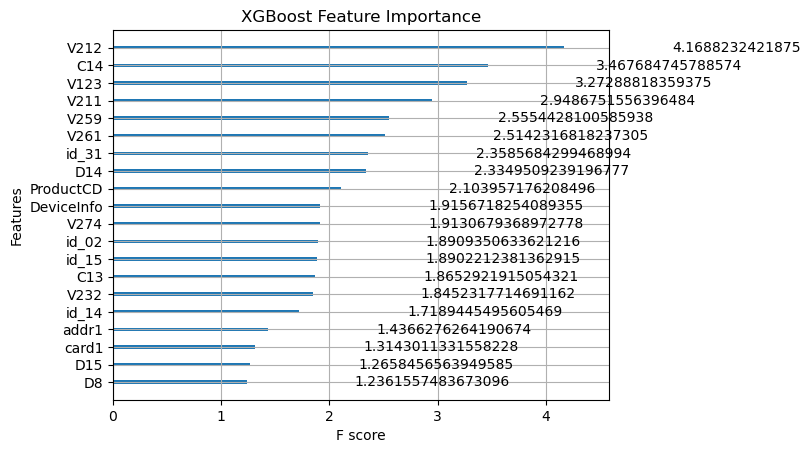

In [51]:
import matplotlib.pyplot as plt
import xgboost as xgb

xgb.plot_importance(result_m, max_num_features=20, importance_type="gain")
plt.title("XGBoost Feature Importance")
plt.show()
